In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import yfinance as yf
from ta import add_all_ta_features 
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.2)
plt.style.use(style="seaborn")

In [2]:
ticker = 'KO'
start = '2010-01-04'
end = '2021-08-13'
df = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume")
df = df.drop(['trend_psar_up', 'trend_psar_down'], axis = 1)
df = df[71:-1] #to skip NuNs genrated for moving avarages etc.
df.head()

/Users/dmitry.volkov/.pyenv/versions/3.8.6/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/dmitry.volkov/.pyenv/versions/3.8.6/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-16,27.115000,27.570000,27.084999,27.485001,19.381353,35075600,1.294820e+08,39486600,0.133260,1.288105e+06,...,-27.830160,0.179383,27.255297,0.182253,-0.704730,-6.467657,5.762927,1.308520,1.300033,-3.629032
2010-04-19,27.490000,27.660000,27.459999,27.660000,19.504751,26468600,1.559506e+08,65955200,0.142880,1.765802e+06,...,-11.320819,0.192882,27.262219,0.581818,1.424443,-4.889237,6.313680,0.636708,0.634690,-3.015430
2010-04-20,27.610001,27.645000,27.160000,27.235001,19.205055,32508800,1.334961e+08,33446400,0.098171,-4.602005e+05,...,-51.415035,0.166515,27.262004,-1.500901,5.116061,-2.888178,8.004238,-1.536512,-1.548439,-4.505609
2010-04-21,27.285000,27.290001,27.000000,27.094999,19.106333,19263200,1.268535e+08,14183200,0.037189,-7.797252e+05,...,-64.622687,0.100603,27.259730,-1.221294,3.281575,-1.654227,4.935802,-0.514049,-0.515375,-4.996498
2010-04-22,27.070000,27.254999,27.000000,27.155001,19.148647,20295600,1.312312e+08,34478800,0.089530,-4.943696e+05,...,-58.962188,0.087353,27.257648,0.036840,2.152398,-0.892902,3.045301,0.221448,0.221203,-4.786114


In [4]:
from sklearn.preprocessing import MinMaxScaler

df_train = df[df.index < '2020-01-01']
df_test = df[('2020-01-01' < df.index) & (df.index < '2021-01-01')]
df_final = df[('2021-01-01' < df.index) & (df.index <= '2021-08-13')]

In [5]:
X_train = np.array(df_train.drop(['Open', 'High', 'Low', 'Close', 'Adj Close'], axis = 1))
X_test = np.array(df_test.drop(['Open', 'High', 'Low', 'Close', 'Adj Close'], axis = 1))

y_train = np.array(df_train.Close)
y_test = np.array(df_test.Close)


X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test = y_scaler.transform(np.array(y_test).reshape(-1, 1))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2445, 82) (2445,) (253, 82) (253,)


#### Labeling

We want to predict the stock price at a future time. We'll predict the stock price at time t + 1 relative to the stock price at time t.

As we're going to use an LSTM architecture, we know that it has memory and that it is maintained by setting the time step, basically how many steps in the past we want the LSTM to use.

The time step  refers to how many steps in time we want the backpropagation algorithm to use when calculating gradients for weight updates during training.

So we can use a method to create both the timestep and the output variable, the t + 1.

In [6]:
n = 30
Xtrain = []
ytrain = []
Xtest = []
ytest = []
for i in range(n, len(X_train)):
    Xtrain.append(X_train[i - n : i, : X_train.shape[1]])
    ytrain.append(y_train[i])  # predict next record
for i in range(n, len(X_test)):
    Xtest.append(X_test[i - n : i, : X_test.shape[1]])
    ytest.append(y_test[i])  # predict next record

In an LSTM network the input for each LSTM layer needs to contain the following information:
- The number of observations
- The time steps
- The features

Therefore we need to add a temporal dimension compared to a classical network:

(number of observations, number of steps, number of features per step)

In [7]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [8]:
print(Xtrain.shape)
print(ytrain.shape)
print("---")
print(Xtest.shape)
print(ytest.shape)

(2415, 30, 82)
(2415,)
---
(223, 30, 82)
(223,)


#### LSTM Model

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

Model architecture
1. LSTM with 100 neurons in the first visible layer
2. 2 neurons in the output layer for predicting close price.
3. The input shape will be 30 time step with 89 features.
4. I use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
5. The model will be fit for 100 training epochs with a batch size of 70.


In [20]:
model = Sequential()
model.add(LSTM(64, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
# model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(
    Xtrain, ytrain, epochs=200, validation_data=(Xtest, ytest), batch_size=70, verbose=1
)

Epoch 1/200
35/35 [==============================] - 2s 25ms/step - loss: 1622.5698 - val_loss: 2280.3352
Epoch 2/200
35/35 [==============================] - 1s 16ms/step - loss: 1583.8317 - val_loss: 2234.7373
Epoch 3/200
35/35 [==============================] - 1s 16ms/step - loss: 1546.7751 - val_loss: 2189.9053
Epoch 4/200
35/35 [==============================] - 1s 16ms/step - loss: 1510.3940 - val_loss: 2145.8584
Epoch 5/200
35/35 [==============================] - 1s 16ms/step - loss: 1474.7393 - val_loss: 2102.5317
Epoch 6/200
35/35 [==============================] - 1s 19ms/step - loss: 1439.7533 - val_loss: 2059.7815
Epoch 7/200
35/35 [==============================] - 1s 19ms/step - loss: 1405.3884 - val_loss: 2017.8761
Epoch 8/200
35/35 [==============================] - 1s 20ms/step - loss: 1371.6808 - val_loss: 1976.6964
Epoch 9/200
 9/35 [======>.......................] - ETA: 0s - loss: 1353.9584

KeyboardInterrupt: 

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               73200     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 73,402
Trainable params: 73,402
Non-trainable params: 0
_________________________________________________________________


In [12]:
trainPredict = model.predict(Xtrain)
testPredict = model.predict(Xtest)

# invert predictions
trainPredict = y_scaler.inverse_transform(trainPredict)
testPredict = y_scaler.inverse_transform(testPredict)

trainPredict = [x[0] for x in trainPredict]
testPredict = [x[0] for x in testPredict]

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

y_train_real = y_scaler.inverse_transform(y_train[n:])
train_mse = mean_squared_error(y_train_real, trainPredict, squared=True)
train_rmse = mean_squared_error(y_train_real, trainPredict, squared=False)
train_r2 = r2_score(y_train_real, trainPredict)
# calculate root mean squared error
test_mse = mean_squared_error(df.Close[n - len(y_test) :], testPredict, squared=True)
test_rmse = mean_squared_error(df.Close[n - len(y_test) :], testPredict, squared=False)
test_r2 = r2_score(df.Close[n - len(y_test) :], testPredict)




print('Train scores:')
print(f'R2   :  {train_r2:.2f}')
print(f"MSE  :  {train_mse:.2f} ")
print(f"RMSE :  {train_rmse:.2f} \n")


print('Test scores:')
print(f'R2   :  {r2_score(df.Close[n - len(y_test) :], testPredict):.2f}')
print(f"MSE  :  {test_mse:.2f} ")
print(f"RMSE :  {test_rmse:.2f} ")

Train scores:
R2   :  0.45
MSE  :  19.07 
RMSE :  4.37 

Test scores:
R2   :  -22.24
MSE  :  145.93 
RMSE :  12.08 


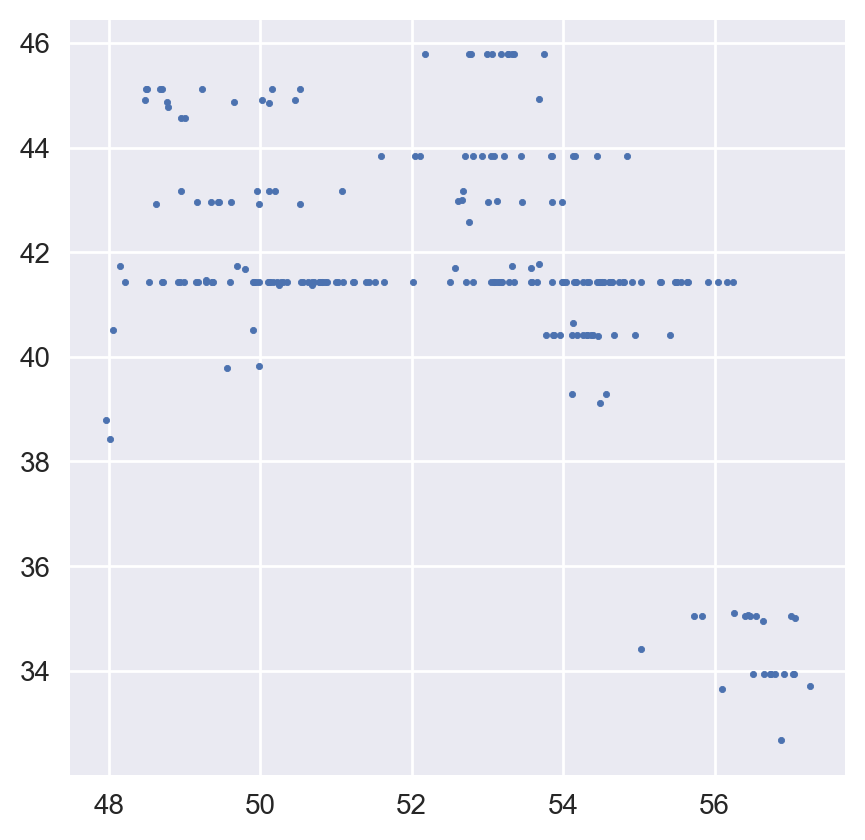

In [14]:
plt.figure(figsize=(5,5), dpi=200)
plt.scatter(df.Close[n - len(y_test) :], testPredict, s=5)

<AxesSubplot:xlabel='Date', ylabel='Close'>

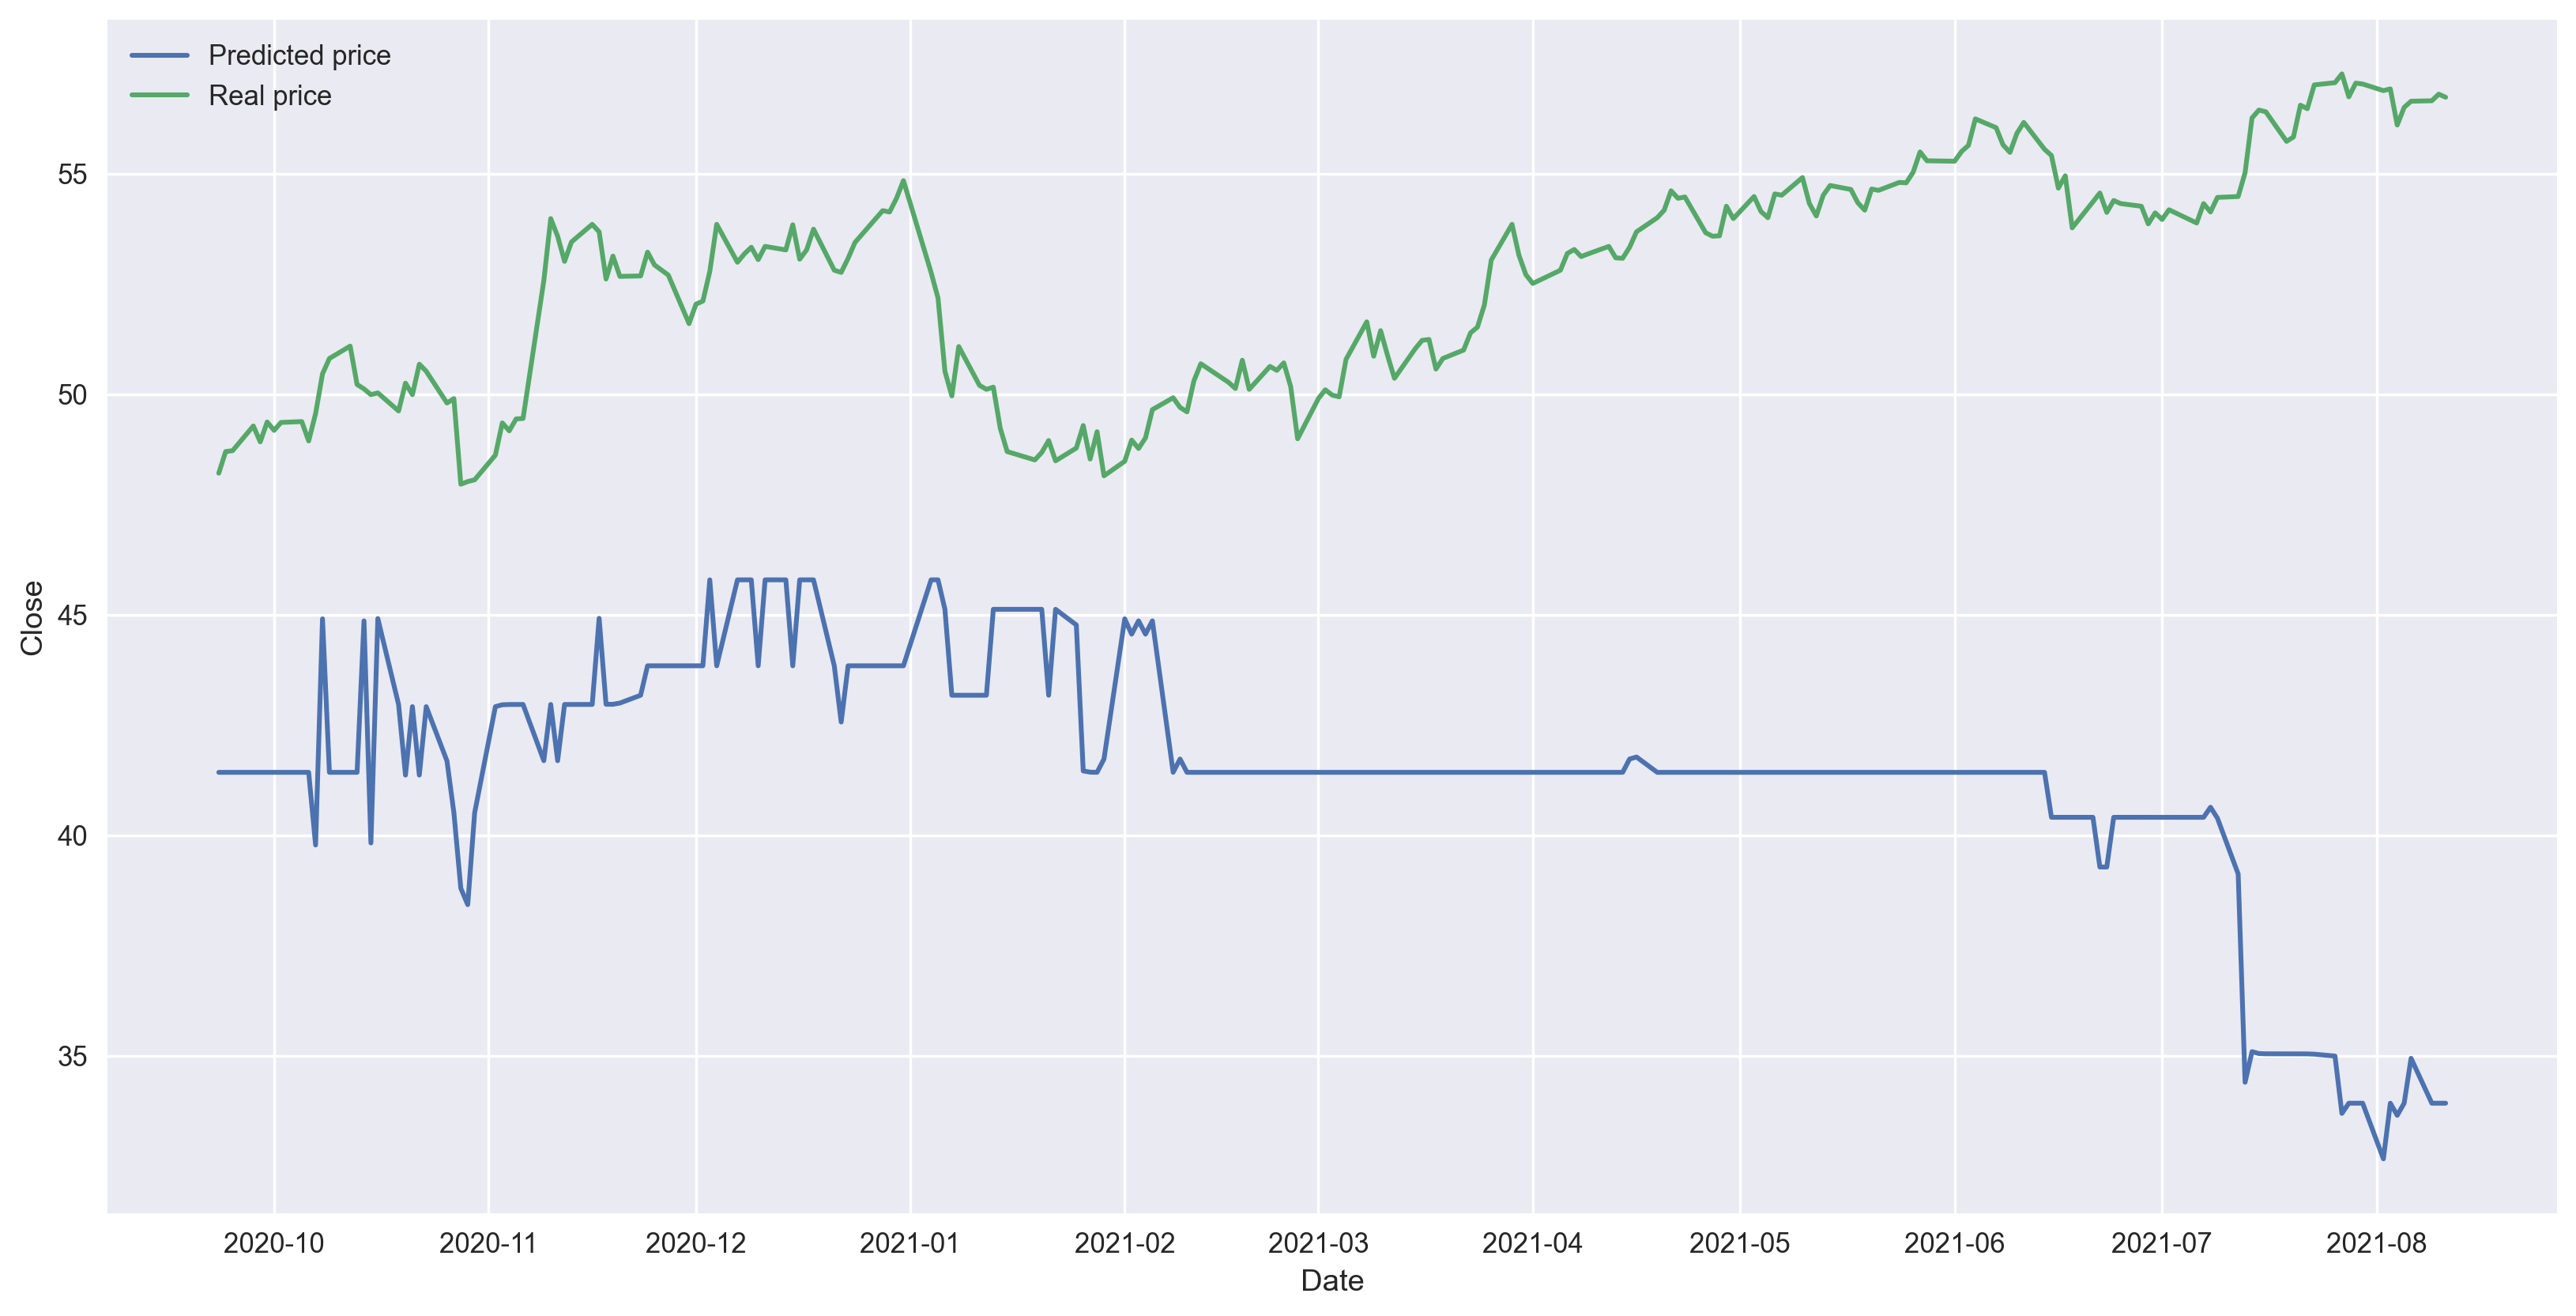

In [15]:
plt.figure(figsize=(16, 8), dpi=250)
sns.lineplot(x = df.index[n - len(y_test) :], y = testPredict, label='Predicted price')
sns.lineplot(x = df.index[n - len(y_test) :], y = df.Close[n - len(y_test) :], label='Real price')